# Connecting to the Device

In [22]:
# Connect to the device
import belay
device = belay.Device("COM7")

In [68]:
# Command Codes
GET_DISTANCE = 0x02
STOP_GET_DISTANCE = 0x0F
GET_CORRECTION_PARAMS = 0x12
CONFIG_ADDRESS = 0x16
ACK = 0x10

In [78]:
def packetsToint(input : list) -> int:
    noPackets = len(input)
    runningSum = 0
    for packetIndex in range(noPackets, 0, -1):
        runningSum = (runningSum) * 256 + input[packetIndex-1]
    return runningSum

def byteArryToHex(arry):
    return ' '.join('{:02x}'.format(x) for x in arry)
    
def intTo2Packets(inputVal : int) -> list:
    lsb = inputVal % 256
    msb = int(inputVal / 256)
    return [lsb, msb]

def calChecksum(body : list) -> int:
    checksum = 0
    for chunk in body:
        checksum += chunk
    return checksum % 256

In [79]:
def shortLidar(commandCode : int, data: list = []):
    startChars = [0xAA,0xAA,0xAA,0xAA]
    deviceId = 0x01
    packetOffset = [0x00, 0x00]
    dataLenth = intTo2Packets( len(data) )
    body = [deviceId, commandCode] + packetOffset + dataLenth + data
    checksum = calChecksum(body)
    msg = startChars + body + [checksum]
    retVal = sendLidarMsg(msg)
    return retVal

@device.task
def sendLidarMsg(msg : list):
A function that is used to read the data from the lidar.
    def retrieveLidarMsg(uart, retryUntilAA = True) -> bytearray:
        from time import sleep
        import machine
        preData = b""
        if retryUntilAA:
            aCount = 0
            retryCount = 0
            while aCount < 4:
                charRead = uart.read(1)
                sleep(0.01)
                if charRead == b"\xaa":
                    aCount += 1
                else:
                    retryCount += 1
                    aCount = 0
                assert retryCount < 500, f"Count not find start of the string aa 4 times, retried {retryCount} times"
            preData += b"\xaa\xaa\xaa\xaa"
        preData += uart.read(6)
        dataLen = devicePacketsToint(preData[-2:])
        data = b""
        while len(data) < dataLen:
            lenToRead = dataLen + 1 - len(data)
            newData = uart.read(lenToRead)
            if newData:
                data += newData
            else:
                sleep(0.05)
        assert dataLen+1 == len(data), f"Incorrect amount of data received.\r\nExpected {dataLen+1}\r\nReceived {len(data)}"
        return preData + data
        pass
    def devicePacketsToint(input : list) -> int:
        noPackets = len(input)
        runningSum = 0
        for packetIndex in range(noPackets, 0, -1):
            runningSum = (runningSum) * 256 + input[packetIndex-1]
        return runningSum
    import machine
    from time import sleep
    uartPort = 0
    uartSpeed = 921600
    uart = machine.UART(uartPort, uartSpeed)
    uart.write(bytearray(msg))
    sleep(0.1)
    # return uart.read()
    retVal = retrieveLidarMsg(uart)
    return retVal


In [80]:
# Test code to make sure that the commands work
retVal = shortLidar(GET_CORRECTION_PARAMS)
print(retVal)

b'\xaa\xaa\xaa\xaa\x00\x12\x00\x00\x12\x00\x8c\x00\x00\x00\x8c\x00\x00\x00(\x17\x00\x00\xd0\x14\x00\x00P\x00\xaf'


# Calibration

## Message Sent: 
```python
ld07_getCorrectionData = [0xAA,0xAA,0xAA,0xAA,0x01,0x12,0x00,0x00,0x00,0x00,0x13]
```

|Characters            | CharNo | Description                              |
|                  ---:|---     |:---                                      |
| 0xAA,0xAA,0xAA,0xAA, |0-3     | Start Characters                         |
| 0x01,                |4       | Device Address 1                         |
| 0x12,                |5       | Command Code - Get Correction Parameters |
| 0x00,0x00,           |6-7     | Packet Offset 0                          |
| 0x00,0x00,           |8-9    | Data Length 0                            |
|                      |        | Data: None                               |
| 0x13                 |10      | Checksum (0x01 + 0x12)                   |

## Return Value:
```python
b'\xaa\xaa\xaa\xaa\x00\x12\x00\x00\x12\x00\x8c\x00\x00\x00\x8c\x00\x00\x00(\x17\x00\x00\xd0\x14\x00\x00P\x00\xaf'
```

|Characters                                                                                                       | CharNo                                           | Description |
|                                                                                                             ---:|---                                               |:---         |
| \xaa\xaa\xaa\xaa                                                                                                |0-3                                               | Start Characters |
| \x00                                                                                                            |4                                                 | Device Address 0 |
| \x12                                                                                                            |5                                                 | Command Code - Get Correction Parameters |
| \x00\x00                                                                                                        |6-7                                               | Packet Offset 0 |
| \x12\x00                                                                                                        |8-9                                               | Data Length 18 bits |
|  <br /> \x8c\x00\x00\x00 <br /> \x8c\x00\x00\x00 <br /> \x28\x17\x00\x00 <br /> \xd0\x14\x00\x00 <br /> \50\x00 |<br/>10-13<br/>14-17<br/>18-21<br/>22-25<br/>26-27| Data <br /> coe_k[0] = 140 <br /> coe_k[1] = 140 <br /> coe_b[0] = 5928 <br /> coe_b[1] = 5328 <br /> Points = 80 |
| \xaf                                                                                                            |28                                                | Checksum = 175 > 0xAF Hex |


## Converted to a coefficient used in distance calculations: 
``` C
 double k0 = (double)coe_k[0]/10000 = 0.0140； 
 double k1 = (double)coe_k[1]/10000 = 0.0140； 
 double b0 = (double)coe_b[0]/10000 = 0.5928； 
 double b1 = (double)coe_b[1]/10000 = 0.5328；
```

## Explanation
K0 and B0 are the distance calculation parameters of left camera;  
K1 and B1 are the distance calculation parameters of right camera;  
80 is the number of distance data points measured by a single camera, indicating totally 160 data points in the two cameras. 

In [81]:
retVal = shortLidar(GET_CORRECTION_PARAMS)
print(f"returned Value: {byteArryToHex(retVal)}")
k0 = packetsToint(retVal[10:14]) / 10000.0
print(f"k0: {k0}")
k1 = packetsToint(retVal[14:18]) / 10000.0
print(f"k1: {k1}")
b0 = packetsToint(retVal[18:22]) / 10000.0
print(f"b0: {b0}")
b1 = packetsToint(retVal[22:26]) / 10000.0
print(f"b1: {b1}")


returned Value: aa aa aa aa 00 12 00 00 12 00 8c 00 00 00 8c 00 00 00 28 17 00 00 d0 14 00 00 50 00 af
k0: 0.014
k1: 0.014
b0: 0.5928
b1: 0.5328


# Get the distance data

In [92]:
retVal = b'\xaa\xaa\xaa\xaa\x00\x10\x00\x00\x02\x00\x0f\x01"'
# Note: The initial command gets an ACK message, so I'm just sending it over and over
# In the final code I should just be able to read the distance
while retVal[5] == 16:
    retVal = shortLidar(GET_DISTANCE)
num = byteArryToHex(retVal)
print(retVal)

b'\xaa\xaa\xaa\xaa\x00\x02\x00\x00D\x01j\x0f\x0e\x00\x00\x1e\x00\xfe<"<"<$<&<.<,<2<0<8<@<<<@<D<V<L<h<~<\x84<p<x<\xa4<z<p<|<\xba<\xb4=\x96<\xc0=\xc2=\xde=\xf2=\xd6=\xfc=\xfc=\xfc=\xfc=\xfc=\xf4=\xf4=\xfc=\xfc=\xfc=\xe8=\xfa=\xfc=\xfc=\xfc=\xfc=\xfc=\xfc=\xfc=\xfc=\xfc=\xfc=\xfc>\xfc>\xfc>\xde>\xd2>\xfc>\xfc>\xf4>\xce>\xda>\xd6>\xe4>\xfc>\xe8>\xe8>\xdc>\xae>\xcc>\xc8>\xc4>\xde>\xcc>\xa6>\xf4>\xa0>\xc8>\xc8>\xbc>\xac>\xa8>\x98>\xc0>\xb2>\xd4>\xb8>\xd4>\xb8>\xe4>\xc8>\xde>\xda>\xc8>\xe0>\xe2>\xe6>\xe4>\xd8?\xd0?\xdc?\xde?\xf8?\xc4?\xe8?\xc4?\xcc?\xdc?\xbe?\xda?\xc0?\xba?\xcc?\xbc?\xdc?\xc6?\xb4?\xcc?\xae?\xae?\xaa?\x98?\x96?\x92?p@~?\x80@|?v@p@v@V@P\xaa\xaa\xaa\xaa\xaa\xaa\xaa\x00\x02\x00\x00D\x01\x0c\x10\x0e\x00\x00\x1e\x00\xfe\x00\x14\x00\x14\x00\x14\x00\x16<\x1e<\x1a<\x18<\x1c\x00\x16\x00\x18<\x1a<\x1c<\x1e'


In [93]:
shortLidar(STOP_GET_DISTANCE)

b'\xaa\xaa\xaa\xaa\x00\x10\x00\x00\x02\x00\x0f\x01"'

In [94]:
print(f"Start Chars {byteArryToHex( retVal[0:4] )}")
print(f"Device Address: {hex( retVal[4] )}")
print(f"Command Code: {hex( retVal[5] )}")
print(f"Packet offset: {byteArryToHex( retVal[6:8] )}")
print(f"Data length: {byteArryToHex( retVal[8:10] )}")
print(f"           : {packetsToint(retVal[8:10])}")

data = retVal[10:-1]
print(f"Data:\r\n{byteArryToHex(data)}")
print(f"  -> Actual Length = {len(data)}")
timestamp = packetsToint( data[0:4] )
print(f"  Timestamp: {timestamp}")
def distConf(data : bytearray):
    retVal = []
    for i in range(160):
        tmpMeasurement = int.from_bytes(data[2*i:2*i+2], byteorder='little')
        tmpConfidence = (tmpMeasurement >> 9) <<1
        tmpDistance = tmpMeasurement & 0x1ff
        retVal.append({"d" : tmpDistance, "c" : tmpConfidence})
    return retVal
distances = distConf(data[4:])
print(f"    Values:\r\n{distances}")
print(len(distances))


Start Chars aa aa aa aa
Device Address: 0x0
Command Code: 0x2
Packet offset: 00 00
Data length: 44 01
           : 324
Data:
6a 0f 0e 00 00 1e 00 fe 3c 22 3c 22 3c 24 3c 26 3c 2e 3c 2c 3c 32 3c 30 3c 38 3c 40 3c 3c 3c 40 3c 44 3c 56 3c 4c 3c 68 3c 7e 3c 84 3c 70 3c 78 3c a4 3c 7a 3c 70 3c 7c 3c ba 3c b4 3d 96 3c c0 3d c2 3d de 3d f2 3d d6 3d fc 3d fc 3d fc 3d fc 3d fc 3d f4 3d f4 3d fc 3d fc 3d fc 3d e8 3d fa 3d fc 3d fc 3d fc 3d fc 3d fc 3d fc 3d fc 3d fc 3d fc 3d fc 3d fc 3e fc 3e fc 3e de 3e d2 3e fc 3e fc 3e f4 3e ce 3e da 3e d6 3e e4 3e fc 3e e8 3e e8 3e dc 3e ae 3e cc 3e c8 3e c4 3e de 3e cc 3e a6 3e f4 3e a0 3e c8 3e c8 3e bc 3e ac 3e a8 3e 98 3e c0 3e b2 3e d4 3e b8 3e d4 3e b8 3e e4 3e c8 3e de 3e da 3e c8 3e e0 3e e2 3e e6 3e e4 3e d8 3f d0 3f dc 3f de 3f f8 3f c4 3f e8 3f c4 3f cc 3f dc 3f be 3f da 3f c0 3f ba 3f cc 3f bc 3f dc 3f c6 3f b4 3f cc 3f ae 3f ae 3f aa 3f 98 3f 96 3f 92 3f 70 40 7e 3f 80 40 7c 3f 76 40 70 40 76 40 56 40 50 aa aa aa aa aa aa aa 00 02 00 00 44 01 0c

In [95]:
from warnings import filterwarnings


filteredDistances = []
filterWindow = 10
for i in range(len(distances)-filterWindow):
    localWindow = [point["d"] for point in distances[i:i+filterWindow]]
    minimum = min( localWindow )
    maximum = max( localWindow )
    if minimum > 0 and (maximum - minimum < 50):
        filteredDistances.append((i, distances[i]["d"]))

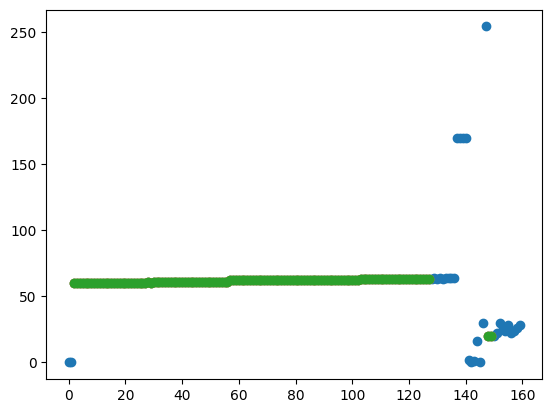

In [96]:
# importing matplotlib module
from matplotlib import pyplot as plt
import numpy as np

x = [i for i in range( len(distances) )]
y = [point["d"] for point in distances]
plt.scatter(x, y)

x = [point[0] for point in filteredDistances]
y = [point[1] for point in filteredDistances]
plt.scatter(x, y)
# print(f"X: {len(x)} / Y: {len(y)}")
 
# Function to plot scatter
plt.scatter(x, y)
 
# function to show the plot
plt.show()

# Done

In [20]:
device._board.close()